## Imports

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mick/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

/Users/mick/anaconda/envs/ee227-py3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
#This loads the file that you want, might take several seconds (up to a minute)
with open("news_sentiment_nn.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")
print("Example article:")
pprint(articles[19])


57767 articles were loaded
Example article:
{b'news_topic': b'ISIS War',
 'introductions': [{b'sentiment_nn': 0.29720652,
                    'person': 'Staffan de Mistura',
                    'text': 'The envoy',
                    'wdid': 'Q1984290'},
                   {b'sentiment_nn': 0.5921626,
                    'person': 'Sergey Lavrov',
                    'text': 'Russian Foreign Minister',
                    'wdid': 'Q58217'},
                   {b'sentiment_nn': 0.38915098,
                    'person': 'John Kerry',
                    'text': 'U.S. Secretary of State',
                    'wdid': 'Q22316'},
                   {b'sentiment_nn': -0.5545976,
                    'person': 'John Kerry',
                    'text': 'in Geneva',
                    'wdid': 'Q22316'},
                   {b'sentiment_nn': 0.6954129,
                    b'wdid': b'233',
                    'person': 'Mohammad Hazzouri',
                    'text': "the head of the city 's Healt

In [4]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

39206  articles from ISIS War and  18561 articles from Brexit were loaded


In [5]:
# get only articles from one story, you can change this
stories = ["ISIS", "BREXIT"]

chosen_story = stories[1]
if chosen_story == "ISIS":
    articles = ISIS_articles
elif chosen_story == "BREXIT":
    articles = Brexit_articles
else:
    raise Exception("No article supported")


## Extract introductions, and obtain their sentiment

In [6]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    sentiments = analyzer.polarity_scores(a['title'])
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        intro['title'] = a['title']
        intro['title_sentiment'] = sentiments['compound']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    sentiments = analyzer.polarity_scores(intro['text'])
    intro['pos_sentiment'] = sentiments['pos']
    intro['neg_sentiment'] = sentiments['neg']
    intro['neu_sentiment'] = sentiments['neu']
    intro['sentiment'] = sentiments['compound']

In [7]:
%load_ext autoreload
%autoreload 2

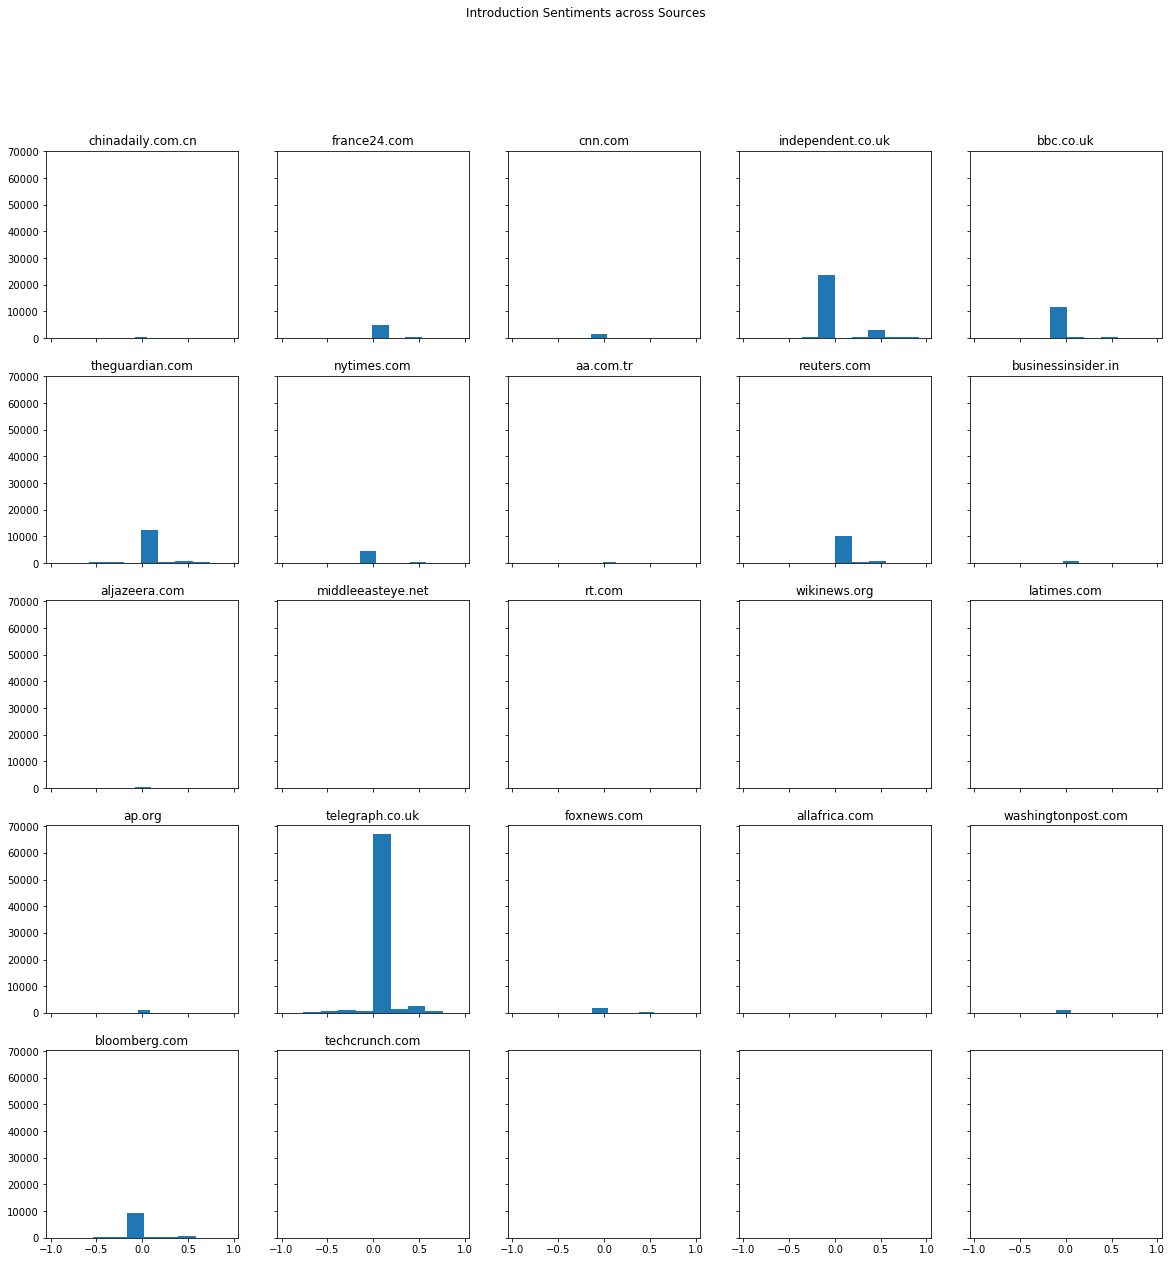

In [8]:
from Visualizer import sentiments_by_sources 
sentiments_by_sources(total_introductions, key='sentiment')

## Augment sentiments

In [9]:
from Featurizer import Featurizer

[nltk_data] Downloading package stopwords to /Users/mick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def add_sentiment_scores(src_file_name, dest_intros, src_key, des_key):
    with open (src_file_name, 'rb') as fp:
        liu_intro = pickle.load(fp)
    Featurizer.transfer_val(liu_intro, dest_intros, [src_key], [des_key], 'wdid', 'person')


In [11]:
def examine_feature_weight(weights, feature_names, show=20):
    contribution = [(i,v) for i,v in enumerate(weights)]
    ranked_contrib = sorted(contribution, key=lambda c: -1 *abs(c[1]))
    for i in range(show):
        c = ranked_contrib[i]
        print(np.around(c[1], decimals=3), feature_names[c[0]])
        

In [12]:
if chosen_story == "ISIS":
    add_sentiment_scores('introductions_liu_isis', total_introductions, 'sentiment', 'liu_sentiment')  
elif chosen_story == "BREXIT":
    add_sentiment_scores('introductions_liu_brexit', total_introductions, 'sentiment', 'liu_sentiment')  
else:
    raise Exception("Not supported..")

In [13]:
from Preprocessing import OneHotFeature

one_hot_feats = OneHotFeature(total_introductions, Featurizer())

Text one hot: (172547, 2617)
Title one hot: (172547, 2617)
Source one hot: (172547, 22)
Person one hot: (172547, 10445)


In [14]:
from Preprocessing import SentimentTarget
sentiment_target = SentimentTarget(total_introductions, ['sentiment', 'liu_sentiment', 'title_sentiment', b'sentiment_nn'])

Sentiments: (172547, 4)


## CCA

In [15]:
from Featurizer import random_indx_same_proportions

In [16]:
def print_shapes(*arg):
    for a in arg:
        if type(a) is not list:
            print(a.shape)
        else:
            print(len(a))

In [17]:
X, X_feats = one_hot_feats.get_combined(['text', 'source'])

In [18]:
Y_keys = [b'sentiment_nn', 'sentiment', 'title_sentiment', 'liu_sentiment']
Y_target, Y_feats = sentiment_target.get_poly(Y_keys)

In [19]:
Y_feats

['',
 "b'sentiment_nn'",
 'sentiment',
 'title_sentiment',
 'liu_sentiment',
 "b'sentiment_nn'^2",
 "b'sentiment_nn'sentiment",
 "b'sentiment_nn'title_sentiment",
 "b'sentiment_nn'liu_sentiment",
 'sentiment^2',
 'sentimenttitle_sentiment',
 'sentimentliu_sentiment',
 'title_sentiment^2',
 'title_sentimentliu_sentiment',
 'liu_sentiment^2']

In [20]:
print_shapes(X, Y_target, X_feats)
assert X.shape[0] == Y_target.shape[0]

(172547, 2639)
(172547, 15)
2639


In [21]:
small_idx = random_indx_same_proportions(total_introductions, 20000)
small_X_cca = X[small_idx]
small_Y_cca = Y_target[small_idx]

In [22]:
print_shapes(small_X_cca, small_Y_cca)

(19998, 2639)
(19998, 15)


In [23]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
cca.fit(small_X_cca, small_Y_cca)

CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [24]:
print("Most positive weights")
pos_weights = np.copy(cca.x_weights_[:,0])
pos_weights[pos_weights < 0] = 0
examine_feature_weight(pos_weights, X_feats, show=20) 
print("Most negative weights")

neg_weights = np.copy(cca.x_weights_[:,0])
neg_weights[neg_weights > 0] = 0
examine_feature_weight(neg_weights, X_feats, show=20) 

Most positive weights
0.655 txt:parti
0.253 txt:justic
0.138 txt:champion
0.126 txt:conserv
0.097 txt:opposit
0.096 txt:hand
0.094 txt:suprem
0.092 txt:best
0.088 txt:respect
0.085 txt:jame
0.078 txt:liken
0.078 txt:treasuri
0.075 txt:support
0.074 txt:hope
0.072 txt:succeed
0.071 txt:strike
0.071 txt:berni
0.07 txt:friend
0.068 txt:quota
0.066 txt:won
Most negative weights
-0.112 txt:sander
-0.1 txt:anti
-0.094 txt:bond
-0.077 txt:need
-0.069 txt:lead
-0.067 txt:clock
-0.067 txt:refuge
-0.06 txt:stress
-0.056 txt:fail
-0.056 txt:denounc
-0.056 txt:tip
-0.052 txt:deni
-0.05 txt:air
-0.045 txt:snap
-0.045 txt:worri
-0.045 txt:timet
-0.041 txt:abandon
-0.041 txt:right
-0.04 txt:understand
-0.04 txt:crisi


In [25]:
examine_feature_weight(cca.y_weights_[:,0], Y_feats, show=len(Y_feats)) 

0.809 sentiment
0.476 sentiment^2
-0.281 liu_sentiment
-0.185 sentimentliu_sentiment
0.059 b'sentiment_nn'sentiment
-0.028 b'sentiment_nn'
-0.022 liu_sentiment^2
0.017 b'sentiment_nn'^2
-0.015 sentimenttitle_sentiment
-0.006 title_sentimentliu_sentiment
0.002 b'sentiment_nn'liu_sentiment
-0.001 title_sentiment^2
-0.0 b'sentiment_nn'title_sentiment
-0.0 title_sentiment
0.0 


In [26]:
Y_combined = np.matmul(Y_target, cca.y_weights_)

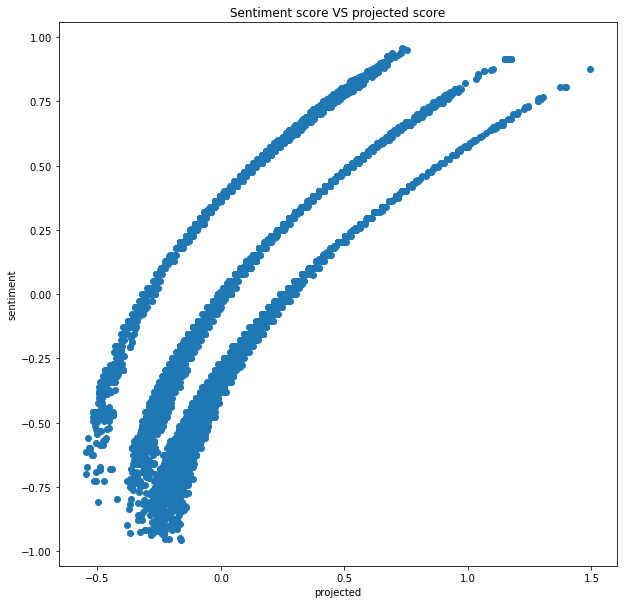

In [27]:
import matplotlib.pyplot as plt
plt.scatter(Y_combined[:], Y_target[:,2])
plt.title("Sentiment score VS projected score")
plt.xlabel("projected")
plt.ylabel("sentiment")
plt.show()

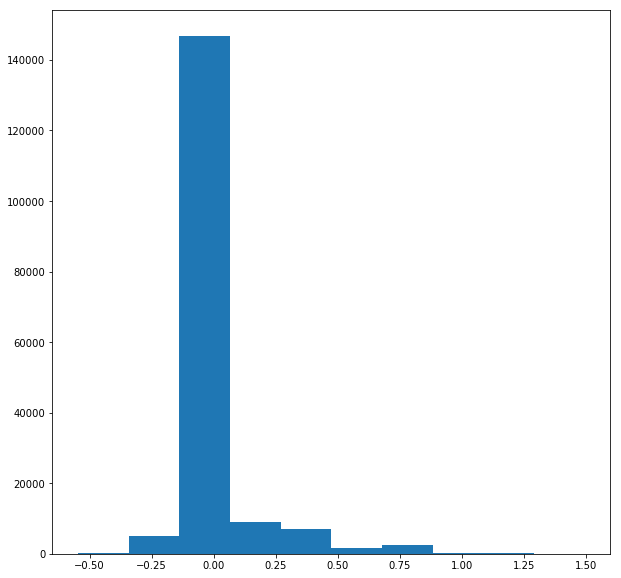

In [28]:
plt.hist(Y_combined)
plt.show()

In [29]:
for i in range(len(total_introductions)):
    total_introductions[i]['processed_sentiment'] = -1 * Y_combined[i][0]

In [30]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 5)
for intro in subsample:
    if intro['processed_sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])
        print("Processed sentiment:", intro['processed_sentiment'])


---------------
Entity mentionned: David Davis
Brexit minister
Sentiment: 0.0
Processed sentiment: 0.00834341792622876
---------------
Entity mentionned: Yvetter Cooper
the shadow Home Secretary
Sentiment: 0.0
Processed sentiment: 0.006247654514704884
---------------
Entity mentionned: Cameron
Mr
Sentiment: 0.0
Processed sentiment: 0.006263021211641951
---------------
Entity mentionned: Corbyn
a 68-year - old peace campaigner
Sentiment: 0.5423
Processed sentiment: -0.18177897421781092
---------------
Entity mentionned: Philip Hammond
foreign secretary
Sentiment: 0.0
Processed sentiment: 0.00808181228421139


## Build a 2-dimensional object containing sentiment per entity, per source

In [31]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['processed_sentiment'])


In [32]:
# An example of how one entity (a city) is described by different sources
# print(ent_source_sent['Aleppo'])

KeyError: 'Aleppo'

In [33]:
# We get rid of entities that don't contain enough data

entities_kept = []
for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 4525  /  13497 in our dataset
We have  22 sources:  ['bbc.co.uk', 'bloomberg.com', 'ap.org', 'telegraph.co.uk', 'techcrunch.com', 'wikinews.org', 'cnn.com', 'aljazeera.com', 'middleeasteye.net', 'foxnews.com', 'latimes.com', 'chinadaily.com.cn', 'aa.com.tr', 'france24.com', 'allafrica.com', 'businessinsider.in', 'nytimes.com', 'rt.com', 'washingtonpost.com', 'independent.co.uk', 'reuters.com', 'theguardian.com']


## We create the array we will use in our sparse model

In [34]:
all_sents = []
for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        all_sents.append(np.array(ent_source_sent[entity][source]))

std_val = np.std(np.concatenate(all_sents))
mean_val = np.mean(np.concatenate(all_sents))

def z_score(sent_val):
    return (sent_val - mean_val) / std_val  

In [110]:
Pos_neg_ratio = 2.0
overall_ratio = 0.15
z_score_thresh = 0.7

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        
        z_scores = np.array([z_score(s) for s in sent_array])
        N_pos = np.sum(z_scores > z_score_thresh)
        N_neg = np.sum(z_scores < -1 * z_score_thresh)   
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({0: 9519, -1: 2581, 1: 997})


In [111]:
def remove_zero_column(mat, sources):
    assert mat.shape[1] == len(sources)
    zero_column = np.sum(np.abs(A), axis=0) == 0
    non_zero = np.logical_not(zero_column)
    selected = np.array(sources)[zero_column]
    print("Removing the following sources ", list(selected))
    return mat[:, non_zero], list(np.array(sources)[non_zero])


## Model source similarity

In [112]:
A_full_ranked, final_sources =  remove_zero_column(A, sources)

Removing the following sources  ['techcrunch.com', 'wikinews.org']


In [113]:
from sklearn.preprocessing import StandardScaler
A_std = StandardScaler().fit_transform(A_full_ranked)


In [114]:
def get_sorted_index(data):
    contribution = [(i,v) for i,v in enumerate(data)]
    ranked_contrib = sorted(contribution, key=lambda c: -1 * (c[1]))
    return [i for (i,v) in ranked_contrib]

def plot_stats_along_sources(A_stats, sources, title):
    assert len(A_stats) == len(sources)
    n = len(sources)
    sorted_idx = get_sorted_index(A_stats)
    plt.bar(np.arange(n), A_stats[sorted_idx])
    plt.xticks(np.arange(n), np.array(sources)[sorted_idx], rotation='vertical')
    plt.title(title)
    plt.show()
    

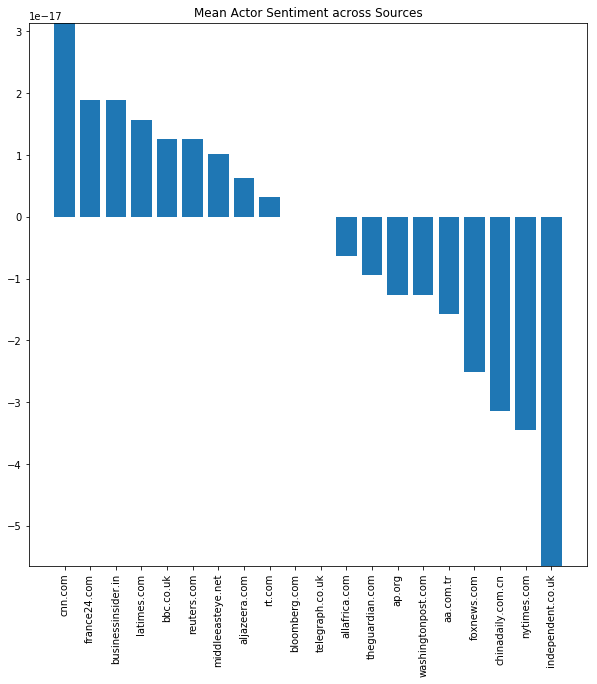

In [115]:
plot_stats_along_sources(np.mean(A_std, axis=0), final_sources, "Mean Actor Sentiment across Sources")

In [116]:
from sklearn.covariance import GraphLasso
graph_lasso = GraphLasso(alpha=0.01)
graph_lasso.fit(A_std)
np.mean(graph_lasso.get_precision() > 0)

for (i, j) in zip(*np.where(abs(graph_lasso.get_precision()) > 0)):
    if i > j:
        print(final_sources[i], final_sources[j])

bloomberg.com bbc.co.uk
ap.org bbc.co.uk
ap.org bloomberg.com
telegraph.co.uk bbc.co.uk
telegraph.co.uk bloomberg.com
telegraph.co.uk ap.org
cnn.com bbc.co.uk
cnn.com bloomberg.com
cnn.com ap.org
cnn.com telegraph.co.uk
aljazeera.com bbc.co.uk
aljazeera.com bloomberg.com
aljazeera.com ap.org
aljazeera.com telegraph.co.uk
aljazeera.com cnn.com
middleeasteye.net bloomberg.com
middleeasteye.net ap.org
middleeasteye.net cnn.com
middleeasteye.net aljazeera.com
foxnews.com bbc.co.uk
foxnews.com bloomberg.com
foxnews.com ap.org
foxnews.com telegraph.co.uk
foxnews.com cnn.com
foxnews.com aljazeera.com
foxnews.com middleeasteye.net
latimes.com bbc.co.uk
latimes.com bloomberg.com
latimes.com ap.org
latimes.com cnn.com
latimes.com aljazeera.com
latimes.com middleeasteye.net
latimes.com foxnews.com
chinadaily.com.cn bbc.co.uk
chinadaily.com.cn bloomberg.com
chinadaily.com.cn ap.org
chinadaily.com.cn aljazeera.com
chinadaily.com.cn middleeasteye.net
chinadaily.com.cn foxnews.com
chinadaily.com.cn l

## Workspace

In [117]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

0.1


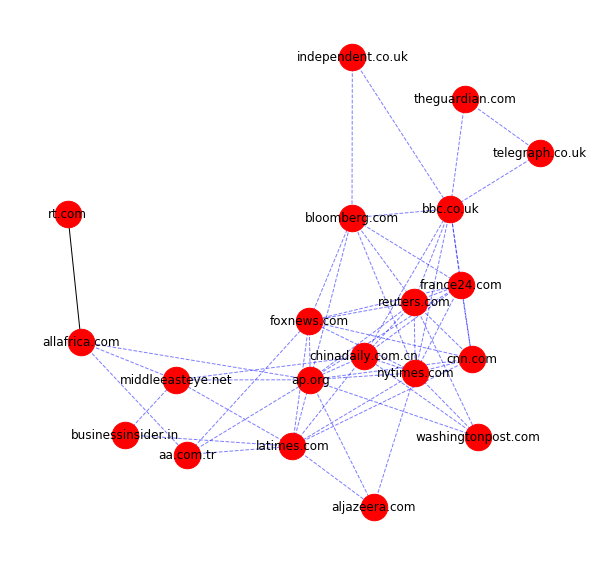

0.11


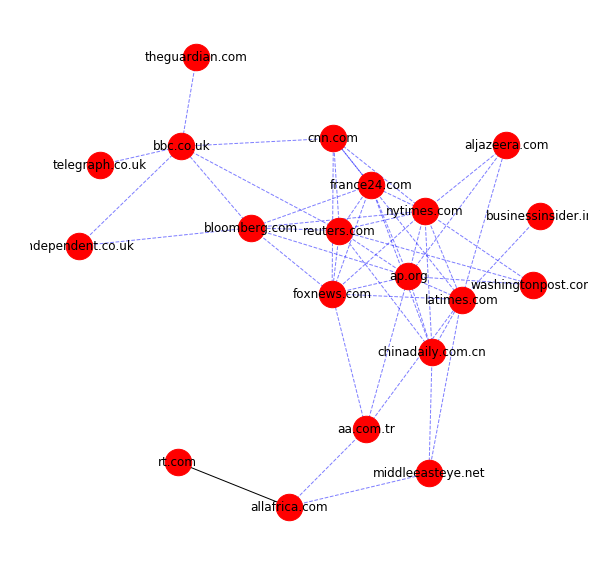

0.12


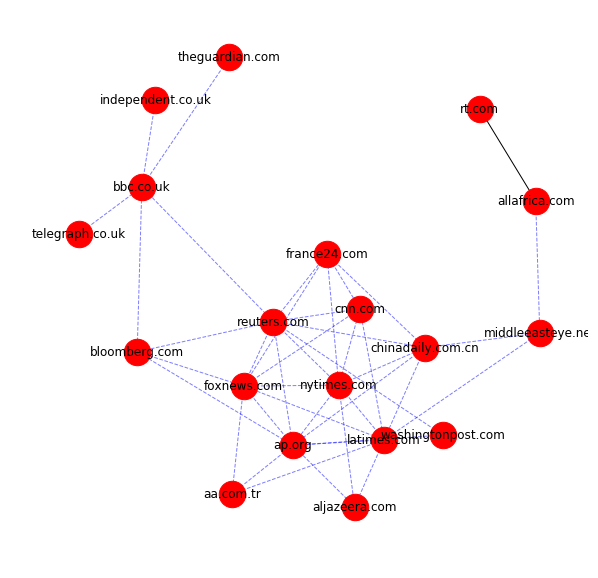

0.13


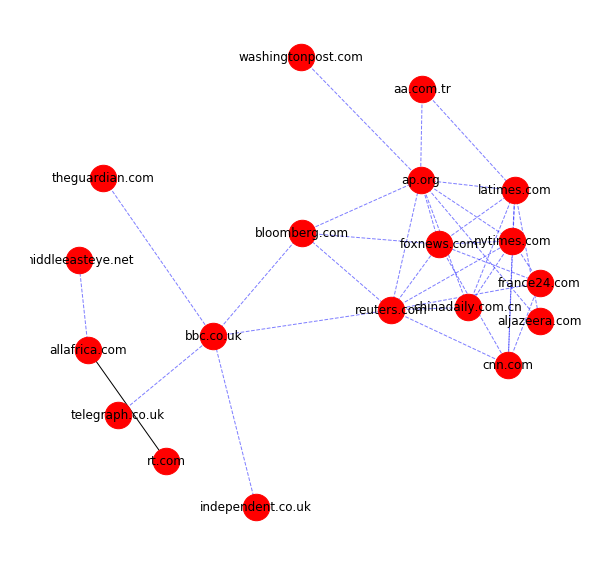

0.13999999999999999


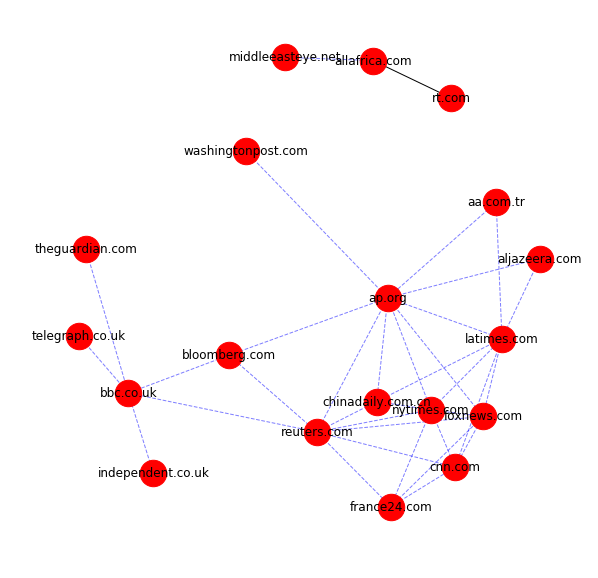

0.14999999999999997


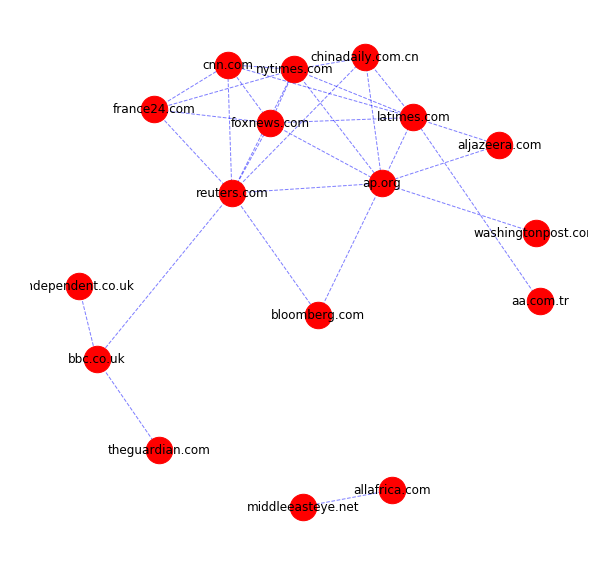

0.15999999999999998


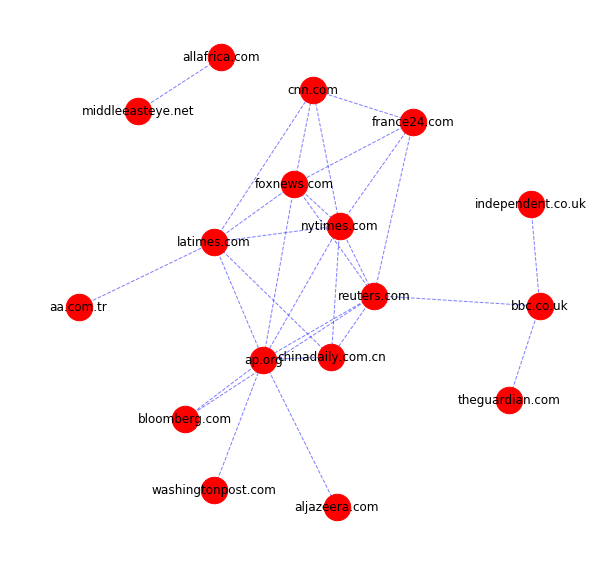

0.16999999999999998


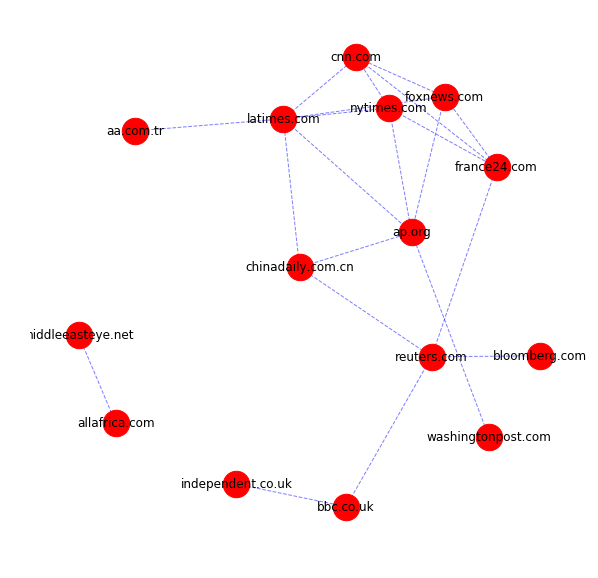

0.17999999999999997


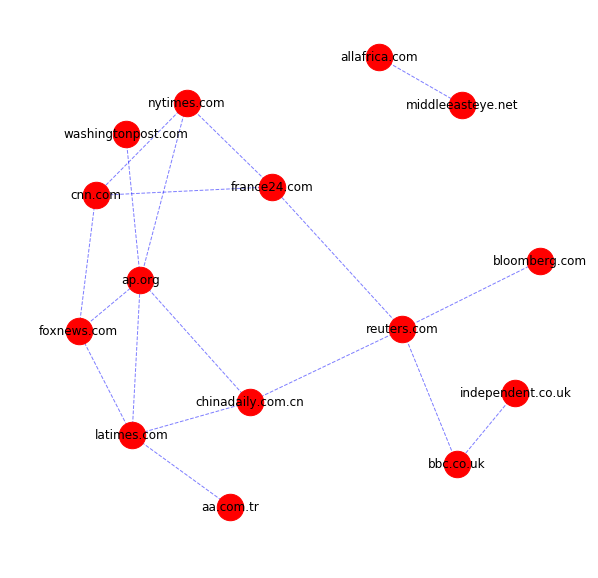

0.18999999999999995


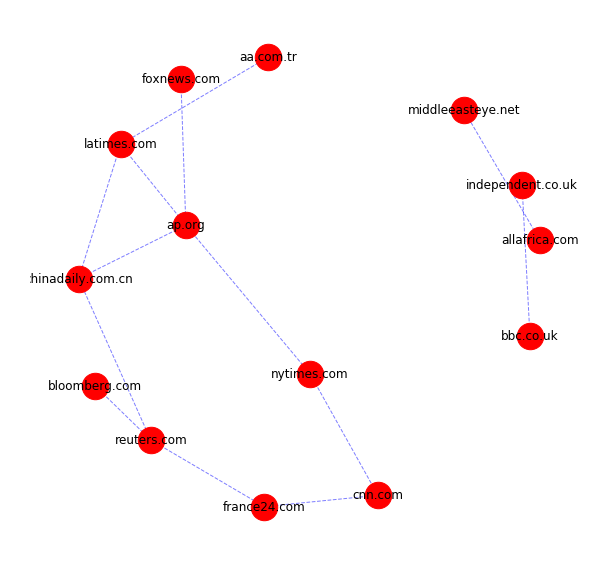

In [119]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    graph_lasso = GraphLasso(alpha=l1_lambda)
    graph_lasso.fit(A_std)
    plot_network(graph_lasso.get_precision(), final_sources)

In [120]:
from GraphicalLasso import GraphicalLasso as GL
from GramLassoSolver import GramLassoSolver as GramLasso
from sklearn import linear_model
def my_graphical_lasso(data, l1_lambda):
    gl = GL(l1_solver_f=GramLasso)
    S = np.cov(data.T)
    return gl.fit(S, l1_lambda)

## Our Glasso: Lambda sweeping

0.1


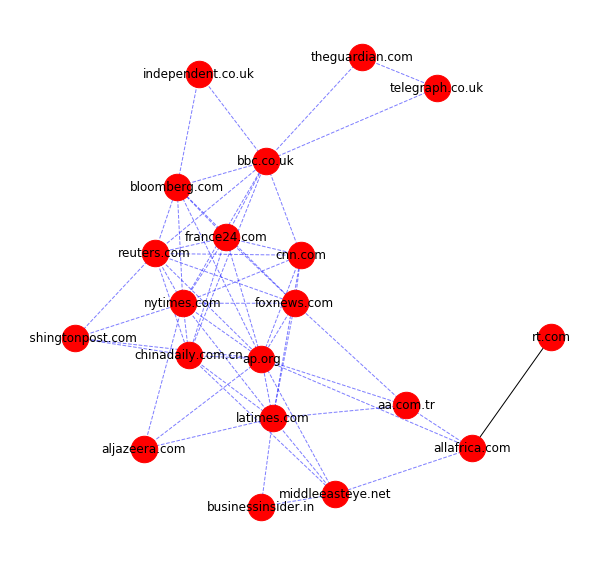

0.11


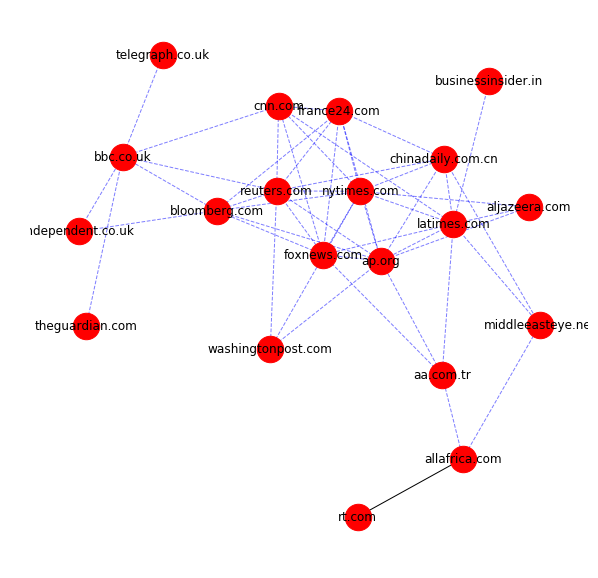

0.12


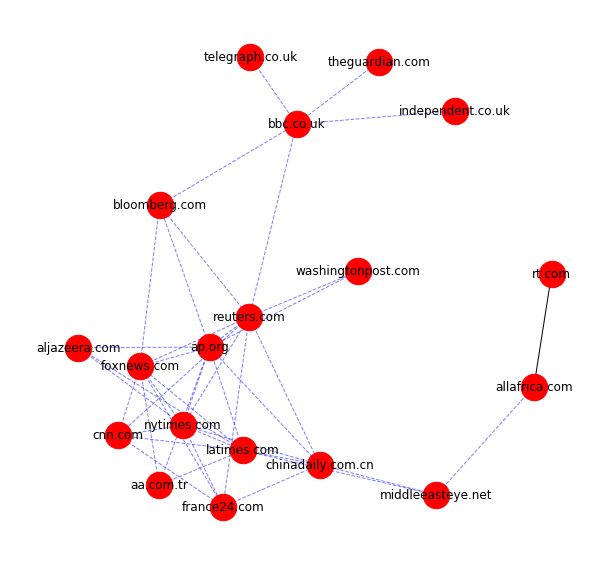

0.13


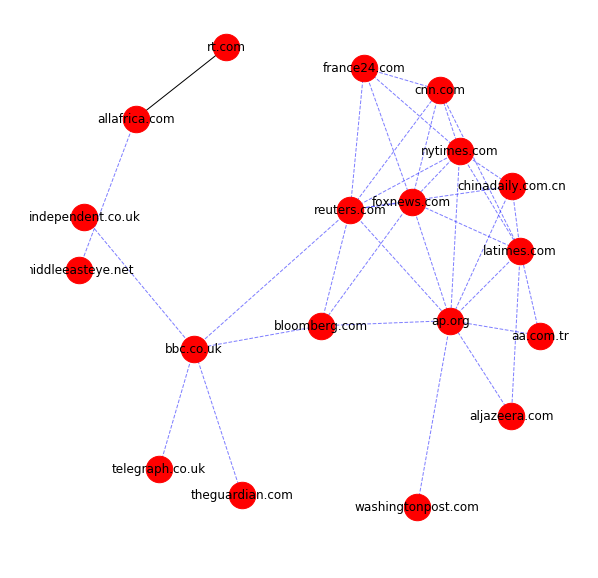

0.13999999999999999


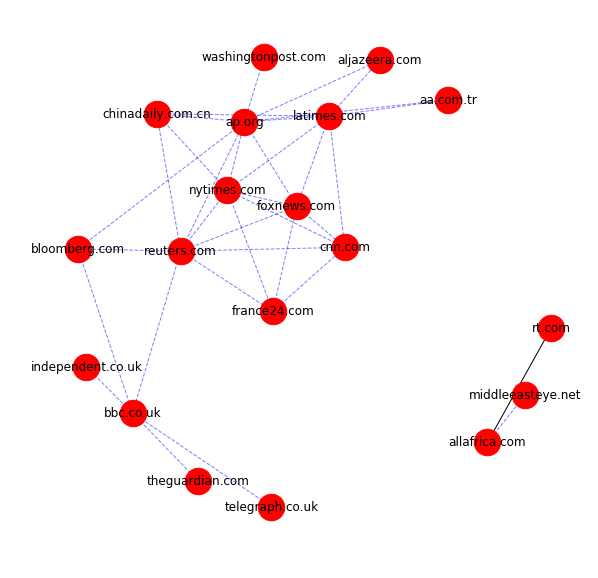

0.14999999999999997


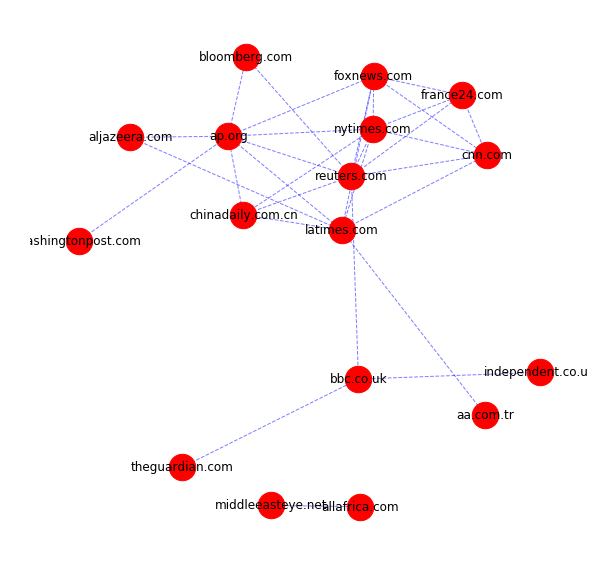

0.15999999999999998


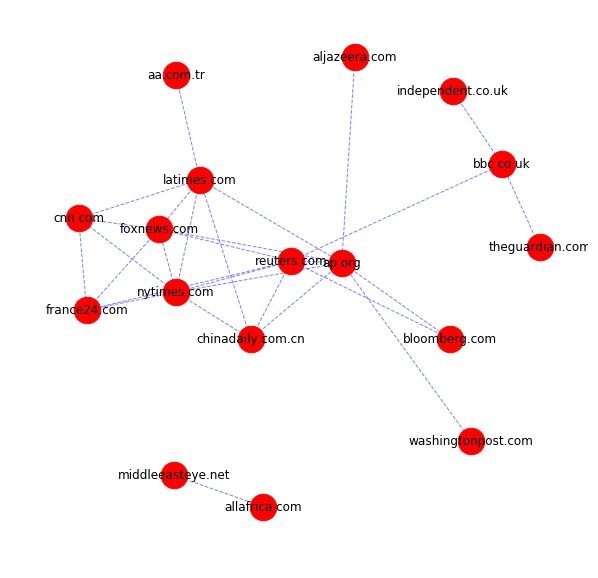

0.16999999999999998


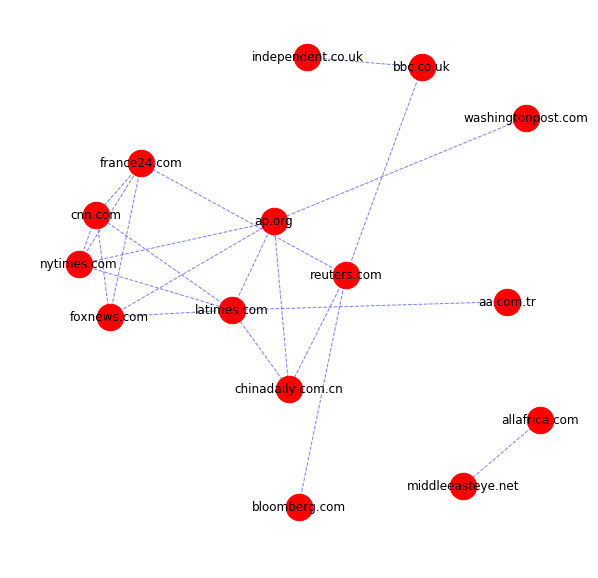

0.17999999999999997


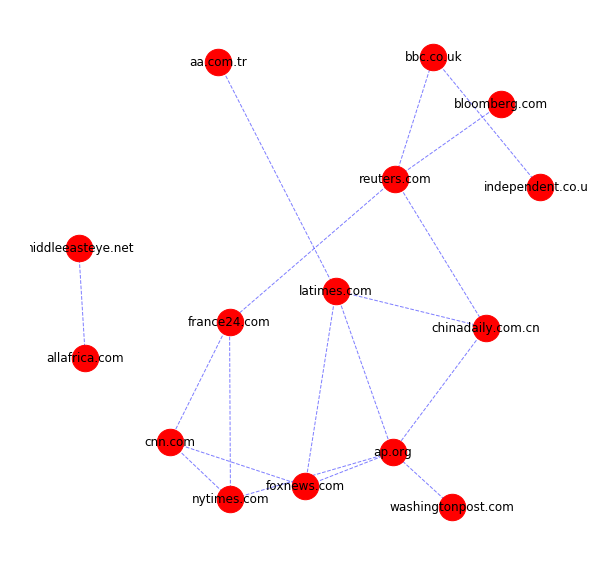

0.18999999999999995


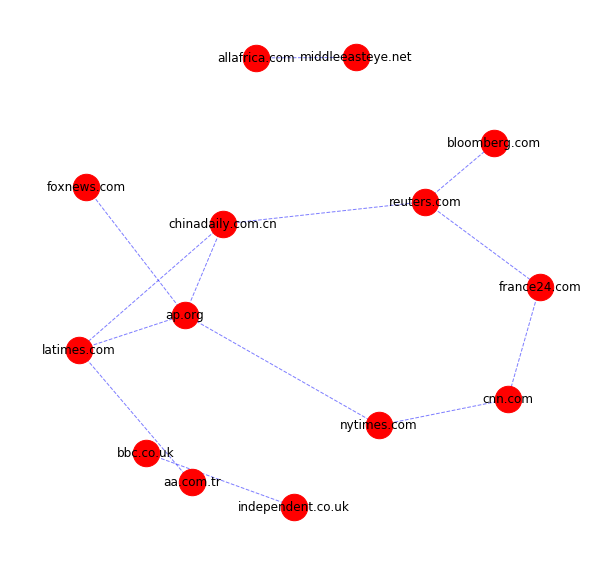

In [121]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    plot_network(my_graphical_lasso(A_std, l1_lambda), final_sources)

## Neighborhood method

In [74]:
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso

In [122]:
n_sel = NGraphSelection(Lasso)
g = n_sel.fit(A_std, 0.10, 'AND')

0.1


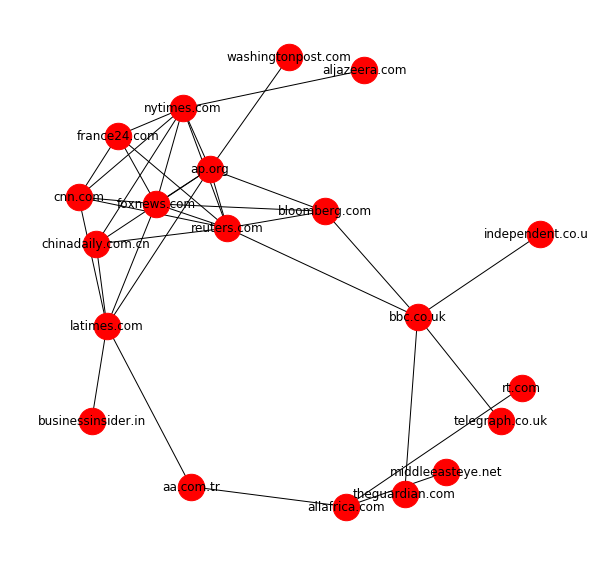

0.11


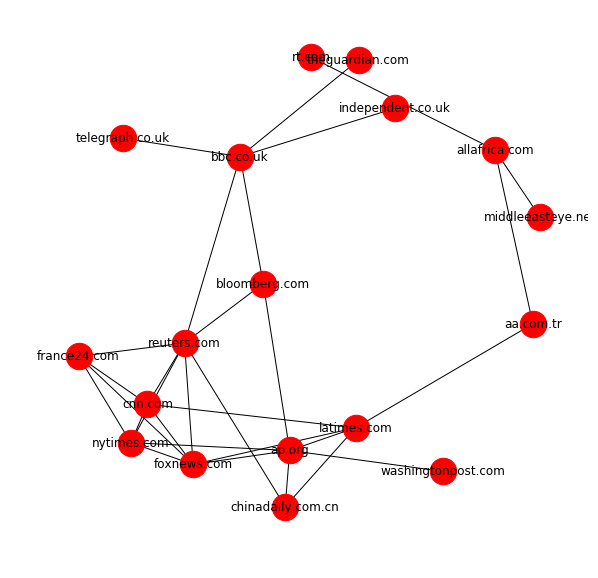

0.12


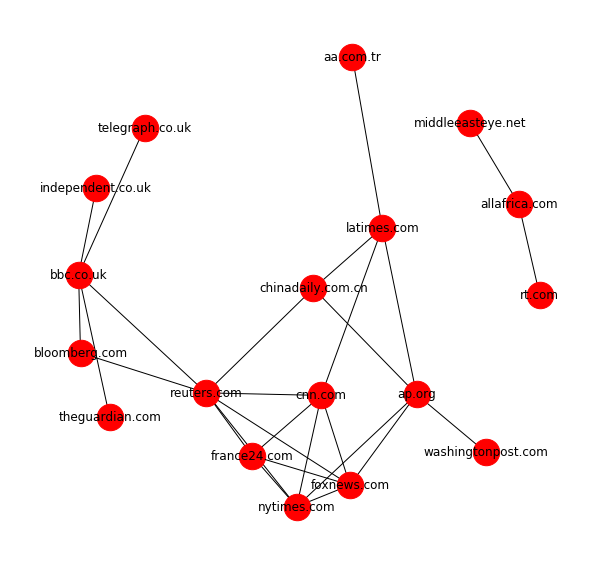

0.13


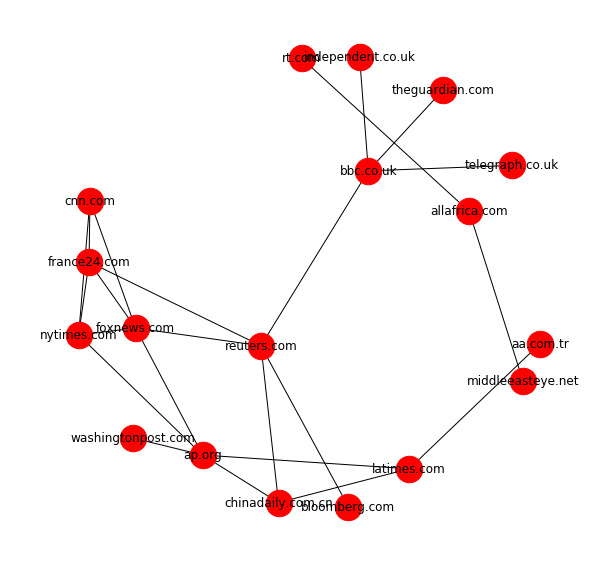

0.13999999999999999


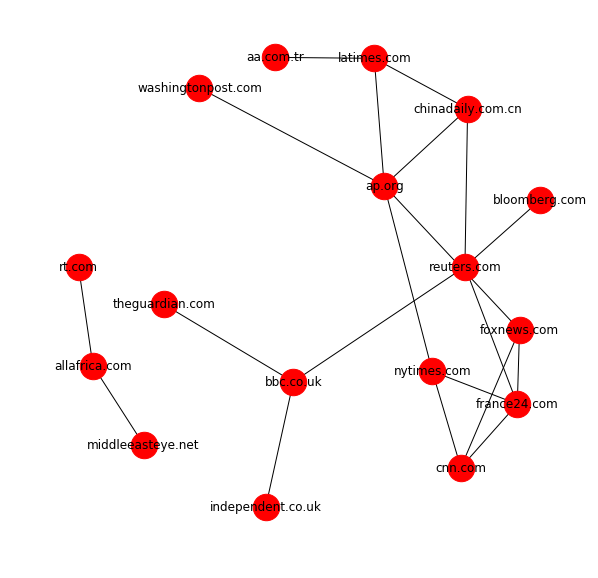

0.14999999999999997


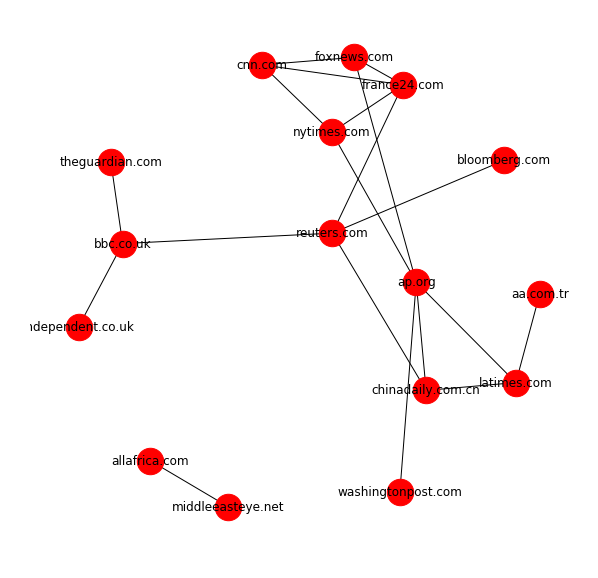

0.15999999999999998


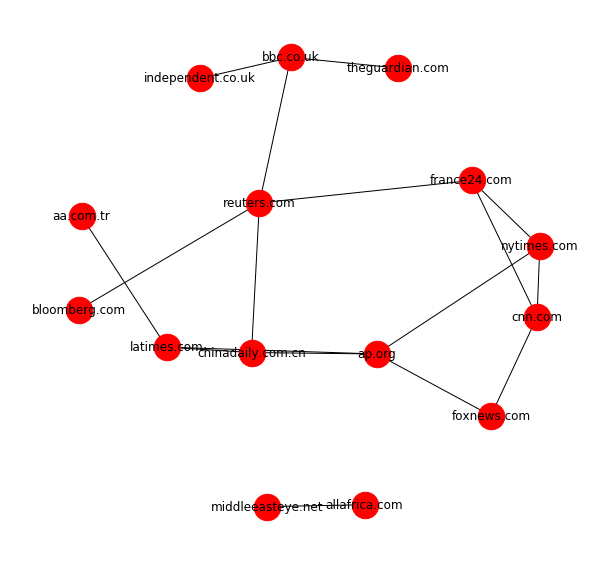

0.16999999999999998


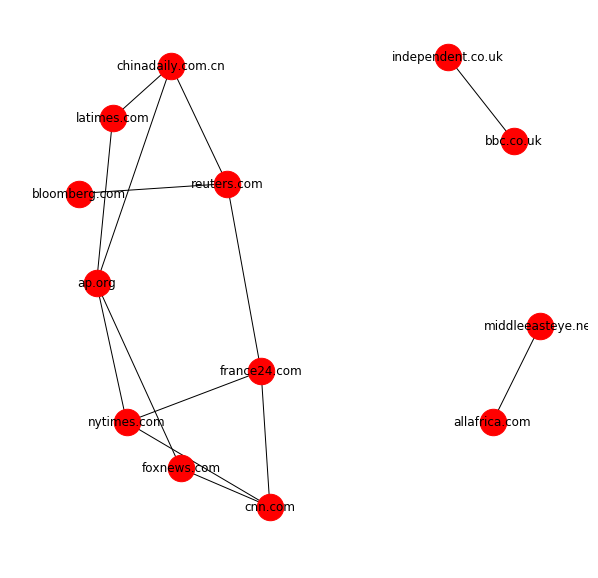

0.17999999999999997


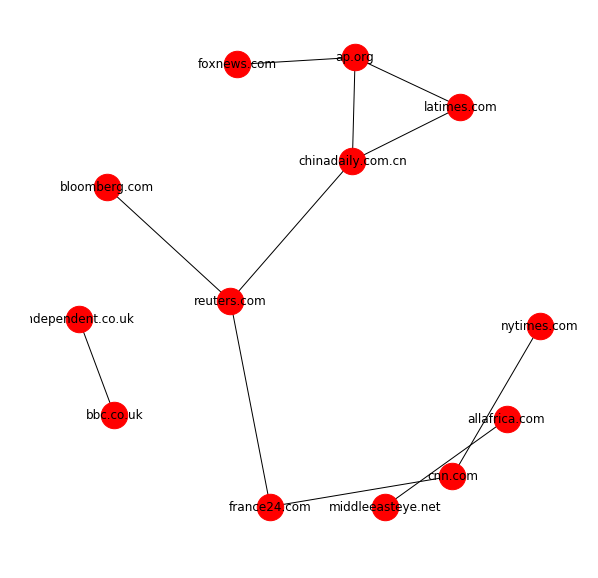

0.18999999999999995


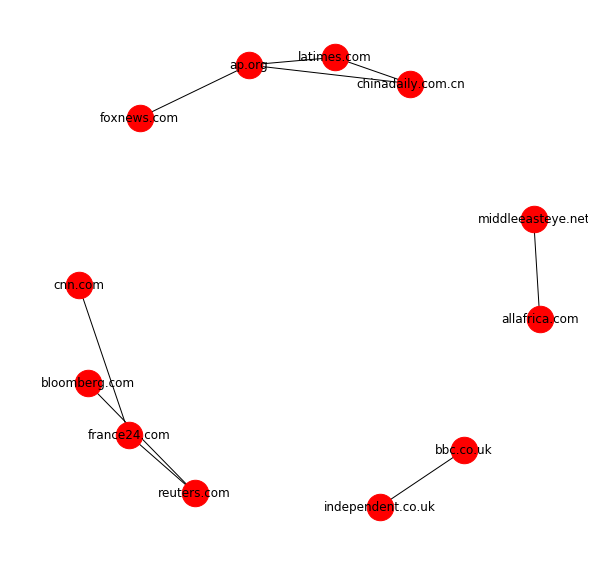

In [123]:
for i in np.arange(0.10,0.20, 0.01):
    l1_lambda = i
    print(l1_lambda)
    plot_network(n_sel.fit(A_std, l1_lambda, 'AND'), final_sources)

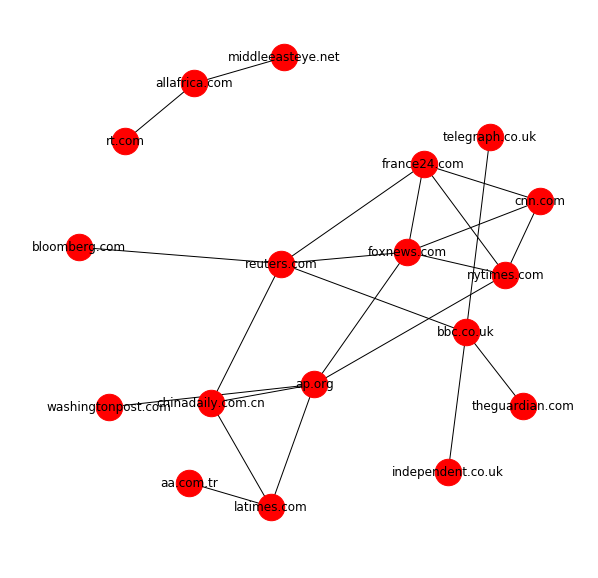

In [147]:
# BREIXT 0.125
# ISIS 0.13
# save_file = "results/fig/" + chosen_story + str(best_lambda).split(".")[1]
best_lambda = 0.13
save_file = None
plot_network(n_sel.fit(A_std, best_lambda, 'AND'), final_sources, save_file)

In [153]:
from datetime import datetime
experiment_name = chosen_story + "-CCA"
params = {
    "pos_neg_ratio": Pos_neg_ratio,
    "overall_ratio": overall_ratio,
    "z_score_thresh": z_score_thresh,
    "lambda": best_lambda,
    "Y_feats": Y_feats,
    "X_feats": X_feats,
}
result = {
    "processing": ["augment_y", "equal sampling", "CCA", "z-score"],
    "A": A,
    "A_std": A_std,
    "sources": final_sources
}
experiment = {
    "params" : params,
    "result": result
}
file_name = "results/" + experiment_name + "_" + datetime.now().strftime('%m%d%H%M%S')
print("Saving " + file_name + "...")
np.save(file_name, experiment)
save = True

Saving results/BREXIT-CCA_0506182153...


'0506182000'